### В рамках данной лабы буду решать задачу мультиклассовой классификации оценки товара (от 1 до 5) исходя из отзыва о нем

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import seaborn as sns

In [2]:
data = pd.read_csv("../input/amazon-music-reviews/Musical_instruments_reviews.csv")

In [3]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


### Данный датасет представляет собой ревью музыкальных инструментов. 

reviewerId - id пользователя

asin - код товара

reviewerName - ник пользователя

helpful - оценка [пальцев вниз, пальцев вверх]

reviewText - текст ревью

overall - оценка от 1 до 5 

summary - оценка текстом

unixReviewTime и reviewTime - время, когда был оставлен отзыв

## Оставим только столбцы reviewText и overall. По reviewText будем классифицировать overall

In [4]:
data = data[['reviewText', 'overall']]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  10254 non-null  object 
 1   overall     10261 non-null  float64
dtypes: float64(1), object(1)
memory usage: 160.5+ KB


Видим, что есть некоторое незначительное количество пропущенных записей. Удалим такие строки полностью

In [6]:
data.dropna(inplace = True)

Рассмотрим количество уникальных значений признака overall

In [7]:
data['overall'].unique()

array([5., 3., 4., 2., 1.])

Оценка от 1 до 5, ее и будем определять

Рассмотрим наиболее употребительные слова для негативных отзывов (оценка 1, 2), нейтральных отзывов (3, 4), положительных отзывов (5)

In [8]:
negative = data[data['overall'].isin([1, 2])].reviewText
neutral = data[data['overall'].isin([3, 4])].reviewText
positive = data[data['overall'] == 5].reviewText

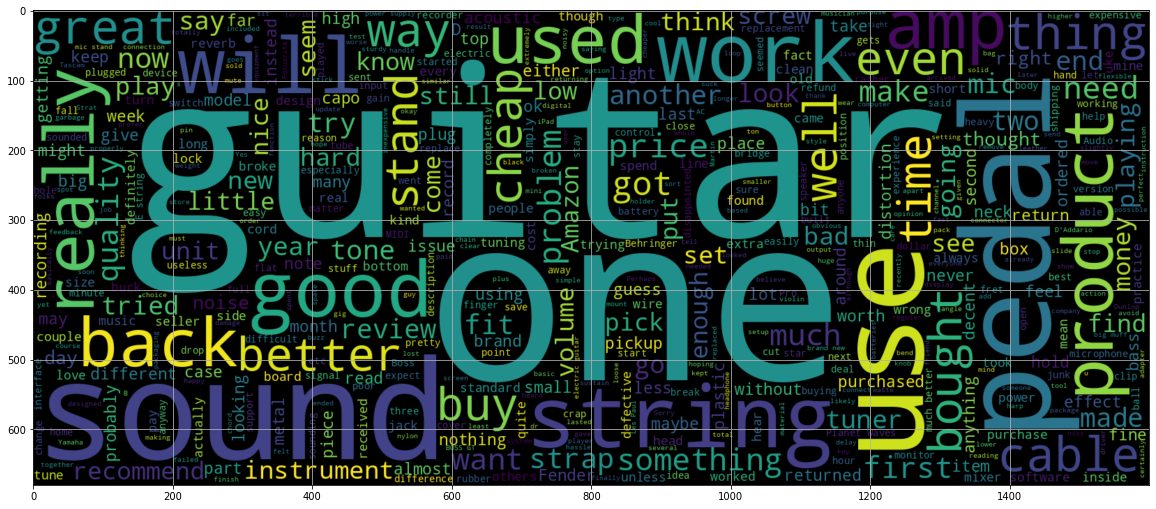

In [9]:
plt.figure(figsize = (20,20)) 
wc_negative = WordCloud(min_font_size = 10,  max_words = 1000 , width = 1600 , height = 680).generate(" ".join(negative))
plt.imshow(wc_negative, interpolation = 'bilinear')
plt.grid(None)

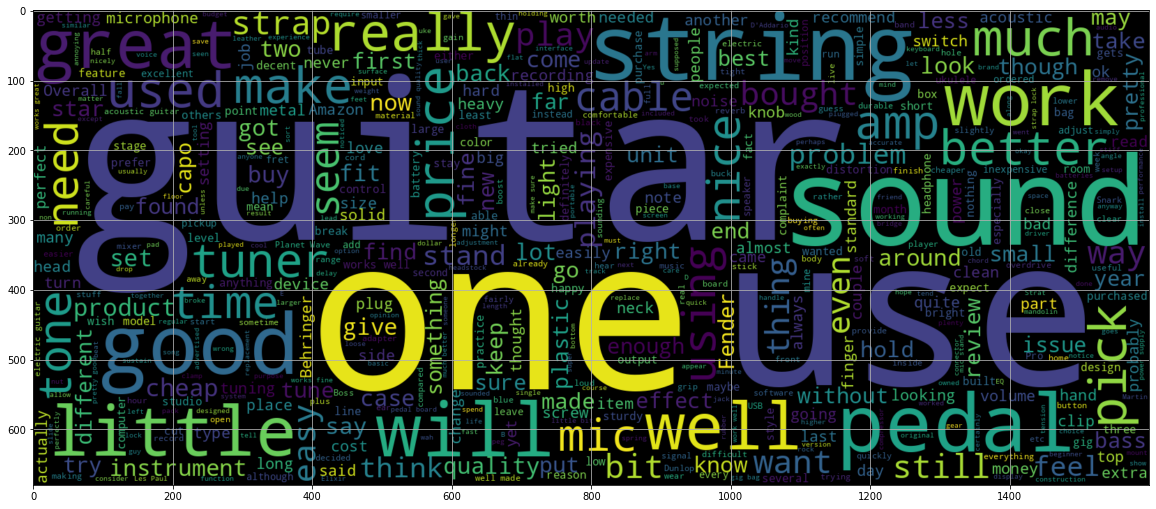

In [10]:
plt.figure(figsize = (20,20)) 
wc_neutral = WordCloud(min_font_size = 10,  max_words = 1000 , width = 1600 , height = 680).generate(" ".join(neutral))
plt.imshow(wc_neutral, interpolation = 'bilinear')
plt.grid(None)

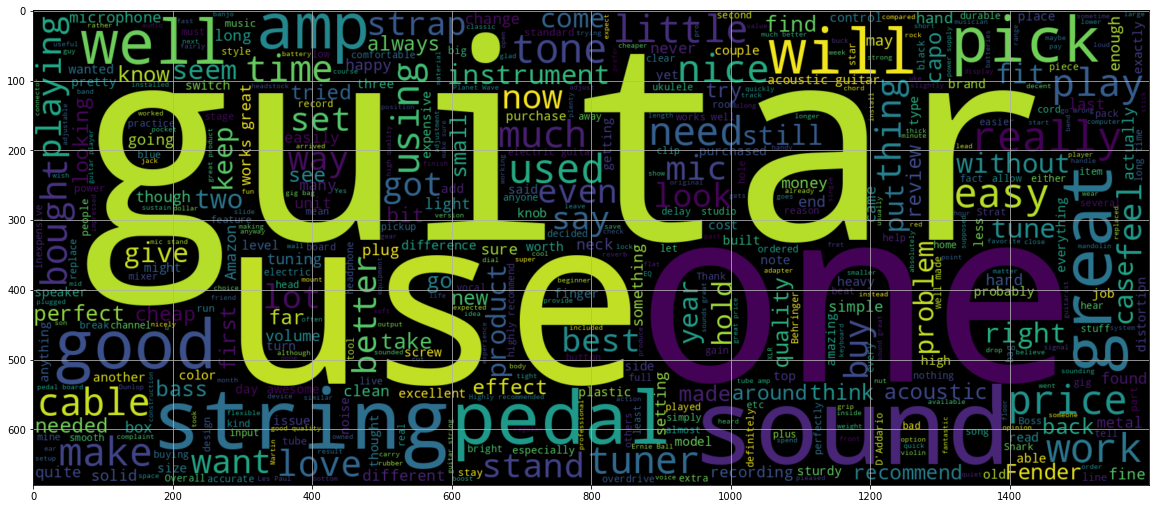

In [11]:
plt.figure(figsize = (20,20)) 
wc_positive = WordCloud(min_font_size = 10,  max_words = 1000 , width = 1600 , height = 680).generate(" ".join(positive))
plt.imshow(wc_positive, interpolation = 'bilinear')
plt.grid(None)

Из графиков можно наблюдать что в негативных отзывов фигурирует больше негативных слов, в позитивных наоборот - больше позитивных слов. В нейтральных преобладает слово good, когда в позитивных great (разная эмоциональная окраска). Предполагаю, что результаты были бы более интересными если убрать нейтральные слова

Также видим что часто встречаются слова guitar, sound, string, pedal, tuner, one, use. Вряд-ли они несут какую-то полезную нагрузку, добавим их к стоп словам

## Препроцессинг starts here

Очистим от знаков препинания и цифр и приводим к нижнему регистру

In [12]:
import re
def clean(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

def lower(text):
    return text.lower()

data['reviewText'] = data['reviewText'].apply(clean)
data['reviewText'] = data['reviewText'].apply(lower)
data.head()

,reviewText,overall
0,not much to write about here but it does exact...,5.0
1,the product does exactly as it should and is q...,5.0
2,the primary job of this device is to block the...,5.0
3,nice windscreen protects my mxl mic and preven...,5.0
4,this pop filter is great it looks and performs...,5.0


Токенизируем получившийся текст (Разбиваем предложение на токены (в нашем случае - слова))

In [13]:
from nltk.tokenize import word_tokenize

In [14]:
data['tokens'] = data['reviewText'].apply(word_tokenize)
data.head()

,reviewText,overall,tokens
0,not much to write about here but it does exact...,5.0,"[not, much, to, write, about, here, but, it, d..."
1,the product does exactly as it should and is q...,5.0,"[the, product, does, exactly, as, it, should, ..."
2,the primary job of this device is to block the...,5.0,"[the, primary, job, of, this, device, is, to, ..."
3,nice windscreen protects my mxl mic and preven...,5.0,"[nice, windscreen, protects, my, mxl, mic, and..."
4,this pop filter is great it looks and performs...,5.0,"[this, pop, filter, is, great, it, looks, and,..."


Удалим токены с длиной < 3

In [15]:
def delete_small(text):
    result = []
    for word in text:
        if len(word) >= 3:
            result.append(word)
    return result

In [16]:
data['tokens'] = data['tokens'].apply(delete_small)

Удалим стоп слова (общеупотребительные слова, не дающие полезной нагрузки для анализа) и выполняем частеречную разметку

In [17]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

In [18]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
stopword_set = set(stopwords.words('english')) | {'guitar', 'sound', 'string', 'pedal', 'tuner', 'one', 'use'}

def token_stop_pos(tokens):
    tags = pos_tag(tokens)
    res = []
    for word, tag in tags:
        if word not in stopword_set:
            res.append(tuple([word, pos_dict.get(tag[0])]))
    return res

In [19]:
data['tagged'] = data['tokens'].apply(token_stop_pos)
data.head()

,reviewText,overall,tokens,tagged
0,not much to write about here but it does exact...,5.0,"[not, much, write, about, here, but, does, exa...","[(much, a), (write, n), (exactly, r), (suppose..."
1,the product does exactly as it should and is q...,5.0,"[the, product, does, exactly, should, and, qui...","[(product, n), (exactly, r), (quite, v), (affo..."
2,the primary job of this device is to block the...,5.0,"[the, primary, job, this, device, block, the, ...","[(primary, a), (job, n), (device, n), (block, ..."
3,nice windscreen protects my mxl mic and preven...,5.0,"[nice, windscreen, protects, mxl, mic, and, pr...","[(nice, a), (windscreen, a), (protects, n), (m..."
4,this pop filter is great it looks and performs...,5.0,"[this, pop, filter, great, looks, and, perform...","[(pop, n), (filter, r), (great, a), (looks, n)..."


Выполним лемматизацию (приведение слов к начальной форме)

In [20]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    res = []
    for word, pos in pos_data:
        lemma = None
        if not pos:
            lemma = word
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)   
        res.append(lemma)
        
    return res

In [21]:
data['lemmatized'] = data['tagged'].apply(lemmatize)
data.head()

,reviewText,overall,tokens,tagged,lemmatized
0,not much to write about here but it does exact...,5.0,"[not, much, write, about, here, but, does, exa...","[(much, a), (write, n), (exactly, r), (suppose...","[much, write, exactly, suppose, filter, pop, s..."
1,the product does exactly as it should and is q...,5.0,"[the, product, does, exactly, should, and, qui...","[(product, n), (exactly, r), (quite, v), (affo...","[product, exactly, quite, affordable, realize,..."
2,the primary job of this device is to block the...,5.0,"[the, primary, job, this, device, block, the, ...","[(primary, a), (job, n), (device, n), (block, ...","[primary, job, device, block, breath, would, o..."
3,nice windscreen protects my mxl mic and preven...,5.0,"[nice, windscreen, protects, mxl, mic, and, pr...","[(nice, a), (windscreen, a), (protects, n), (m...","[nice, windscreen, protects, mxl, mic, prevent..."
4,this pop filter is great it looks and performs...,5.0,"[this, pop, filter, great, looks, and, perform...","[(pop, n), (filter, r), (great, a), (looks, n)...","[pop, filter, great, look, performs, like, stu..."


Рассмотрим распределение оценок

<AxesSubplot:xlabel='overall', ylabel='count'>

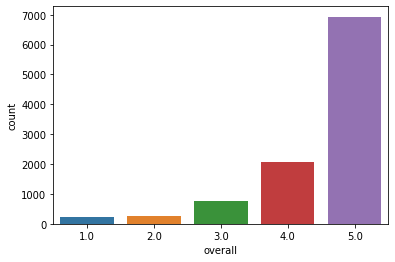

In [22]:
sns.countplot(x = 'overall', data = data)

In [23]:
data.overall.value_counts()[5] / data.overall.value_counts().sum()

0.6760288667836941

Видим, что распределение сильно скошено к оценкам 4 и 5, причем оценку 5 поставили 67 процентов респондентов. Нужно будет делать оверсемплинг

Глянем количество уникальных токенов

In [24]:
unique_tokens = set()

for tokens in data['lemmatized']:
    unique_tokens.update(tokens)


In [25]:
len(unique_tokens)

15321

15321 уникальных токена, что не так много и можно было бы попробовать bag of words. Но исходя из предыдущего опыта на иаде, эмбеденги в 99% случаев дают лучший результат из коробки. Будем использовать word2vec

Так как в будущем будем использовать pytorch, который принимает лейблы классов от 0 до n, то сделаем классы мапперы оценки в индексы и наоборот

In [26]:
class2idx = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4
}

idx2class = {v: k for k, v in class2idx.items()}

Применим к столбцу overall

In [27]:
data['overall'].replace(class2idx, inplace = True)

In [28]:
from sklearn import model_selection

Разобьем данные на тестовые и тренировочные. Используем stratify для того чтобы пропорциональное соотношение классов в train и test было одинаковым

In [29]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(data['lemmatized'], data['overall'], test_size=0.2, random_state = 228, stratify = data['overall'])

word2vec преобразует слова в их векторные представления, учитывающие контекст, в котором слова обычно используются. Все векторные представления одинаковой длины.

Загрузим обученную модель glovetwitter27b100d

In [30]:
from gensim.models import Word2Vec, KeyedVectors

In [31]:
w2vmodel = KeyedVectors.load_word2vec_format('../input/glove100/glove.twitter.27B.100d.txt')

In [32]:
w2vmodel.most_similar(positive = 'good')

[('great', 0.8995507955551147),
 ('well', 0.8844853043556213),
 ('better', 0.8784540891647339),
 ('nice', 0.8719304203987122),
 ('too', 0.850609302520752),
 ('night', 0.8455638885498047),
 ('way', 0.8432667851448059),
 ('but', 0.8425140380859375),
 ('it', 0.8408531546592712),
 ('morning', 0.8380196690559387)]

In [33]:
w2vmodel.most_similar(positive = 'bad')

[('but', 0.849998950958252),
 ('shit', 0.8407027721405029),
 ('really', 0.8376076221466064),
 ('way', 0.8303707838058472),
 ('thing', 0.8276876211166382),
 ("n't", 0.8259332776069641),
 ('right', 0.8235621452331543),
 ('stupid', 0.8233467936515808),
 ('think', 0.8231157064437866),
 ('crazy', 0.8228102922439575)]

In [34]:
vectors = w2vmodel

Приступим к обучению моделей

Для модели полносвязного перцептрона составим вектора предложений. Для этого будем суммировать вектора слов в предложении. Если слова нет в нашем словаре - будем считать его нулевым вектором (в алгоритме не будем суммировать)

In [35]:
def get_sentence_vector(w2vmodel, tokens):
    vector = np.zeros(vectors.vectors.shape[1])
    for token in tokens:
        if token in vectors.key_to_index:
            vector += vectors[token]
            
    return vector

In [36]:
get_sentence_vector(w2vmodel, train_x[0])

array([-3.47453293e+00,  8.83151989e-01,  1.27907289e+00, -3.56549399e+00,
       -2.75625936e-02,  2.24100409e+00,  1.77870702e+00, -4.04743246e+00,
        1.96052942e+00, -7.02059878e-01, -4.23991394e+00, -1.92765071e+00,
       -7.87231001e+01, -3.24404195e+00, -2.45622099e+00,  6.78675777e-01,
        6.17124971e-01,  3.16401601e+00,  3.52830901e+00, -3.32121699e+00,
       -1.51729192e+00,  1.70281518e+00,  2.67699396e+00,  3.27572300e+00,
       -7.58232035e-01,  6.80368790e+00, -6.59092031e-01,  4.49313900e+00,
        2.98513154e+00, -5.02197605e+00, -2.83954789e+00, -7.69407805e-01,
       -7.94164406e+00,  3.00227983e-01, -6.48637876e-01, -2.35115430e+00,
       -7.26336052e-01, -2.65819162e+00,  1.48950287e+00,  1.02020999e+00,
       -7.97482393e+00,  4.11828921e-01, -5.44090983e-01, -7.58710114e-01,
        3.29561899e+00, -1.80614305e+00, -8.75840783e-02, -8.72464966e-01,
       -6.95723109e+00,  6.81403996e+00, -1.45407196e+00,  3.88768806e+00,
       -1.02024589e+01,  

In [37]:
train_sentence_vectors = [get_sentence_vector(w2vmodel, tokens) for tokens in train_x]
test_sentence_vectors = [get_sentence_vector(w2vmodel, tokens) for tokens in test_x]

Приступим к созданию моделей. Будем использовать pytorch

In [38]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tqdm

In [39]:
BATCH_SIZE = 64
EPOCHS = 30
DEVICE = torch.device('cpu')

Формируем TensorDataset. На вход он принимает тензоры - придется привести вектора и целевую переменную к тензору

In [40]:
train_tensor_ds = data_utils.TensorDataset(torch.Tensor(train_sentence_vectors), torch.Tensor(train_y.to_numpy()).type(torch.LongTensor))
test_tensor_ds = data_utils.TensorDataset(torch.Tensor(test_sentence_vectors), torch.Tensor(test_y.to_numpy()).type(torch.LongTensor))

Применим WeightedRandomSampler для балансировки батчей

Если этого не сделать получается такая картинка (модель всегда предсказывает 5)
```
                 precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        43
         1.0       0.00      0.00      0.00        50
         2.0       0.00      0.00      0.00       154
         3.0       0.00      0.00      0.00       417
         4.0       0.68      1.00      0.81      1387

    accuracy                           0.68      2051
   macro avg       0.14      0.20      0.16      2051
weighted avg       0.46      0.68      0.55      2051
```

In [41]:
class_count = train_y.value_counts().sort_index().to_list()
class_weights = 1. / torch.tensor(class_count, dtype = torch.float)
class_weights

tensor([0.0057, 0.0050, 0.0016, 0.0006, 0.0002])

In [42]:
class_weights_all = class_weights[train_y.to_list()]

In [43]:
weighted_sampler = data_utils.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [44]:
#sampler = weighted_sampler
train_dataloader = data_utils.DataLoader(train_tensor_ds, BATCH_SIZE, sampler = weighted_sampler)
test_dataloader = data_utils.DataLoader(test_tensor_ds, BATCH_SIZE)

In [45]:
def my_little_plotter(errors, loss):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    x = range(len(errors))
    train_mse = ax1.plot(x, [y[0] for y in errors], label='train_mse')
    train_mae = ax1.plot(x, [y[1] for y in errors], label='train_mae')
   
    test_mse = ax2.plot(x, [y[2] for y in errors], label='test_mse')
    test_mae = ax2.plot(x, [y[3] for y in errors], label='test_mae')
    
    ax3.plot(loss, label = 'loss')
    ax1.legend()
    ax2.legend()
    ax3.legend()

In [46]:
def get_metrics(model, dataloader, should_print = False, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch, target in dataloader:
            pred = model(batch)
            squared_error += torch.mean(torch.square(torch.argmax(pred, dim = 1) - target).type(torch.FloatTensor))
            abs_error += torch.mean(torch.abs(torch.argmax(pred, dim = 1) - target).type(torch.FloatTensor))
            
    mse = squared_error / len(dataloader)
    mae = abs_error / len(dataloader)
    if should_print:     
        print("%s results:" % (name or ""))
        print("Mean square error: %.5f" % mse)
        print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [47]:
def executor(model, train_dataloader, test_dataloader, epochs = EPOCHS, should_print = False, device = DEVICE):
    #weight = class_weights.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    error_global_progress = []
    loss_global_progress = []
    for epoch in range(epochs):
        if epoch % 10 == 0:
            print(f"epoch: {epoch}")
            
        error_epoch_progress = []
        loss_epoch_progress = []
        for i, (batch, target) in enumerate(train_dataloader):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            
            loss = criterion(pred, target)
            loss_epoch_progress.append(loss)
            loss.backward()
            optimizer.step()

            if i % 15 == 0:
                train_squared_error = torch.mean(torch.square(torch.argmax(pred, dim = 1) - target).type(torch.FloatTensor))
                train_abs_error = torch.mean(torch.abs(torch.argmax(pred, dim = 1) - target).type(torch.FloatTensor))
                
                if should_print:   
                    print('train_mse', train_squared_error, 
                          'train_mae', train_abs_error)
                    
                test_squared_error, test_abs_error = get_metrics(
                    model,
                    test_dataloader,
                    name='val',
                    batch_size=BATCH_SIZE, 
                    device=DEVICE, 
                    should_print = should_print
                )
                test_squared_error, test_abs_error = test_squared_error, test_abs_error
                
                if should_print:
                    print('test_mse', test_squared_error, 
                          'test_mae', test_abs_error)

                error_epoch_progress.append((train_squared_error, train_abs_error, test_squared_error, test_abs_error))  
                
        loss_global_progress.append(loss_epoch_progress)
        error_global_progress.append(error_epoch_progress)

    res = [item for sublist in error_global_progress for item in sublist]
    loss_global_progress = [item for sublist in loss_global_progress for item in sublist]
    
    return res, loss_global_progress

In [48]:
class FullyConnected(nn.Module):
    def __init__(self, input_size = 100, output_size = 5, hid_size = 32):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, hid_size, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hid_size, int(hid_size / 2), bias = True),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.final_layer = nn.Sequential(
            nn.Linear(int(hid_size / 2), output_size, bias = True),
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.final_layer(x)
        return x

FullyConnected(
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (final_layer): Sequential(
    (0): Linear(in_features=32, out_features=5, bias=True)
  )
)
epoch: 0
epoch: 10
epoch: 20
epoch: 30
epoch: 40


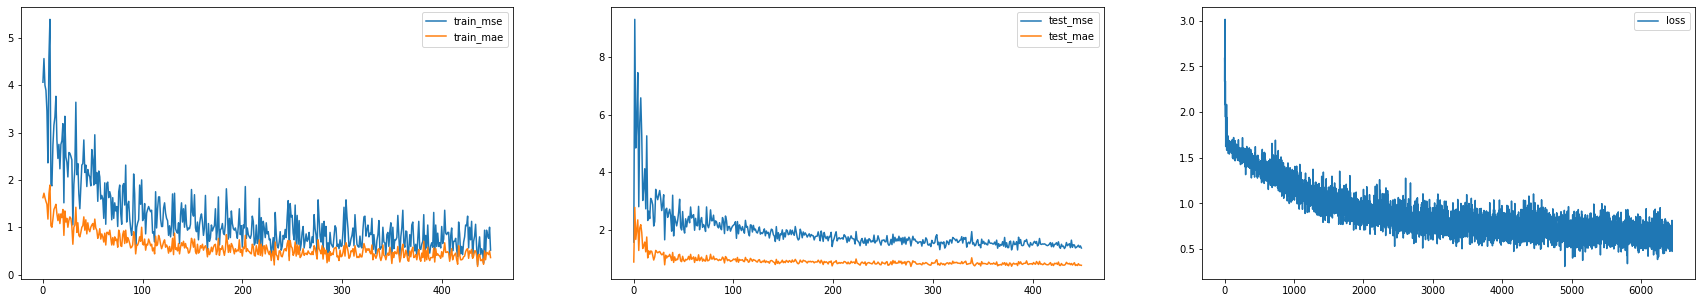

In [49]:
model = FullyConnected(hid_size = 64).to(DEVICE)
print(model)
errors, loss = executor(model, train_dataloader, test_dataloader, should_print = False, epochs = 50)
plt.rcParams["figure.figsize"] = (30, 5)
my_little_plotter(errors, loss)

Видно, что после примерно 20 эпох лосс функция практически не меняется как и ошибка. Можно было бы добавить раннюю остановку но мне лень :<

In [50]:
def get_predicted_y(y_pred):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    return y_pred_tags

In [51]:
with torch.no_grad():   
    model.eval()
    predicted_y = get_predicted_y(model(test_tensor_ds.tensors[0]))

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:>

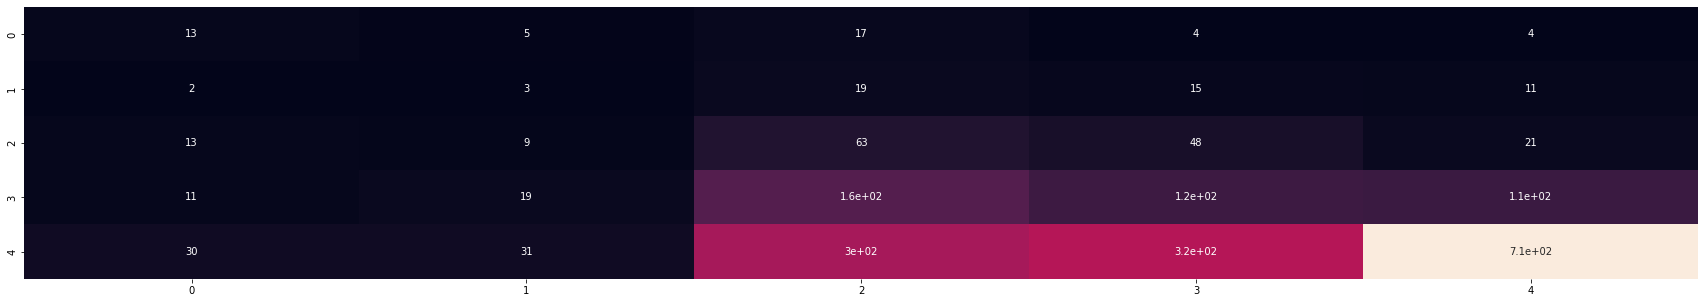

In [53]:
sns.heatmap(confusion_matrix(test_y, predicted_y), annot = True, cbar = False)

In [54]:
print(classification_report(test_y, predicted_y))

              precision    recall  f1-score   support

         0.0       0.19      0.30      0.23        43
         1.0       0.04      0.06      0.05        50
         2.0       0.11      0.41      0.18       154
         3.0       0.23      0.28      0.25       417
         4.0       0.83      0.51      0.63      1387

    accuracy                           0.44      2051
   macro avg       0.28      0.31      0.27      2051
weighted avg       0.62      0.44      0.50      2051



Видно, что алгоритм хорошо определяет класс с наибольшим числом данных, однако точность определения других классов намного хуже. С другой стороны, это лучше чем dummy классификатор, всегда определяющий что пользователь поставит оценку 5

Попробуем сверточную сеть. Теперь наш формат данных где мы делали сумму векторов предложений не подойдет так как нам нужно рассматривать каждое слово по отдельности

Посмотрим распределение количества слов в предложении в каждом тексте

In [55]:
word_counts = [len(x) for x in train_x]

<AxesSubplot:ylabel='count'>

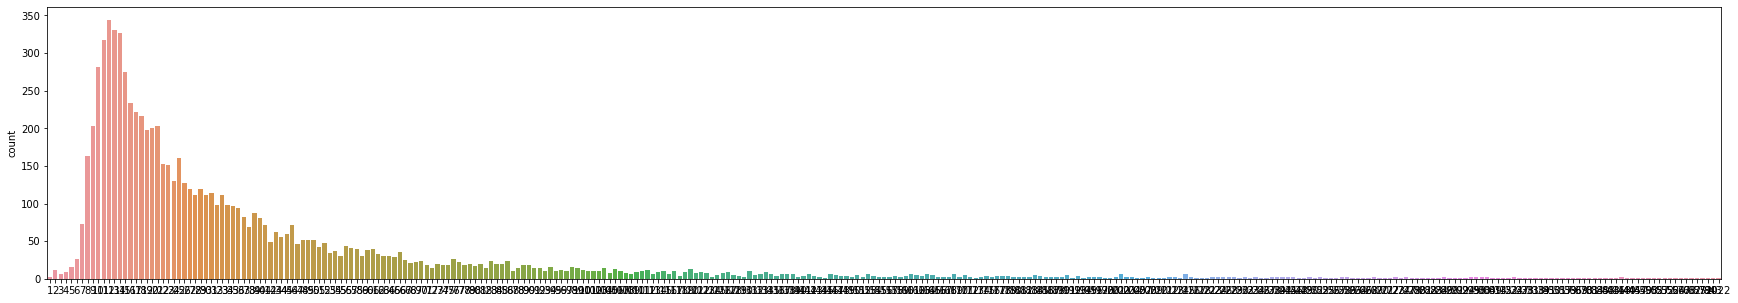

In [56]:
sns.countplot(x = word_counts)

In [57]:
np.mean(word_counts)

41.79617213214677

Видим что в среднем в тексте около 42 слов (классное число, лол). Такое количество мы и возьмем, тогда наша размерность будет 42 x 100. Короткие предложения будем дополнять нулевыми векторами а длинные обрезать до 42 слов

In [58]:
def get_sentence_vector_conv(w2vmodel, tokens, MAX_WORDS = 42):
    zero_vector = np.zeros(vectors.vectors.shape[1])
    vecs = []
    tokens_cut = tokens[0:MAX_WORDS]
    for token in tokens_cut:
        if token in vectors.key_to_index:
            vecs.append(vectors[token])
        else:
            vecs.append(zero_vector)
    
    len_diff = 42 - len(vecs)
    if (len_diff > 0):
        vecs.extend([zero_vector] * len_diff)
        
    return vecs

In [59]:
train_sentence_vectors_conv = [get_sentence_vector_conv(w2vmodel, tokens) for tokens in train_x]
test_sentence_vectors_conv = [get_sentence_vector_conv(w2vmodel, tokens) for tokens in test_x]

In [60]:
train_tensor_ds_conv = data_utils.TensorDataset(torch.Tensor(train_sentence_vectors_conv), torch.Tensor(train_y.to_numpy()).type(torch.LongTensor))
test_tensor_ds_conv = data_utils.TensorDataset(torch.Tensor(test_sentence_vectors_conv), torch.Tensor(test_y.to_numpy()).type(torch.LongTensor))

In [61]:
#sampler = weighted_sampler
train_dataloader_conv = data_utils.DataLoader(train_tensor_ds_conv, BATCH_SIZE, sampler = weighted_sampler)
test_dataloader_conv = data_utils.DataLoader(test_tensor_ds_conv, BATCH_SIZE)

In [62]:
class ConvNetwork(nn.Module):
    def __init__(self, input_size = 100, output_size = 5, kernel_size = 2):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=kernel_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.layer1 = nn.Sequential(
            nn.Linear(64, 64, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 32, bias = True),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.final_layer = nn.Sequential(
            nn.Linear(32, output_size, bias = True),
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.flatten(1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.final_layer(x)
        return x

ConvNetwork(
  (conv1): Sequential(
    (0): Conv1d(100, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveMaxPool1d(output_size=1)
  )
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (final_layer): Sequential(
    (0): Linear(in_features=32, out_features=5, bias=True)
  )
)
epoch: 0
epoch: 10
epoch: 20


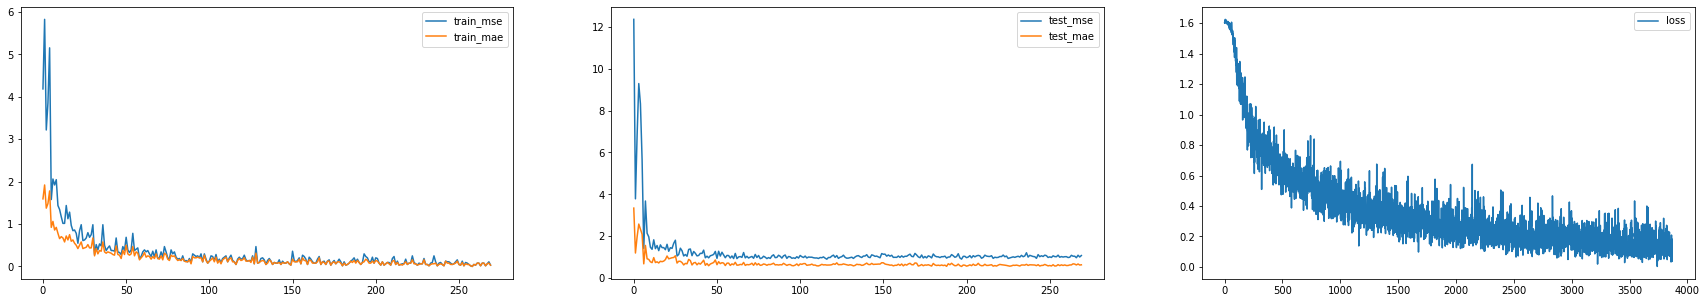

In [63]:
model_conv = ConvNetwork(kernel_size = 3).to(DEVICE)
print(model_conv)
errors, loss = executor(model_conv, train_dataloader_conv, test_dataloader_conv, should_print = False, epochs = 30)
plt.rcParams["figure.figsize"] = (30, 5)
my_little_plotter(errors, loss)

Видим, что блягодаря сверточному слою ошибка на трейне пропорционально меньше. Связываю это с заменой получения вектора предложения через суммирование на обработку отдельных n-грамм (kernel_size)

In [64]:
with torch.no_grad():   
    model_conv.eval()
    predicted_y_conv = get_predicted_y(model_conv(test_tensor_ds_conv.tensors[0]))

<AxesSubplot:>

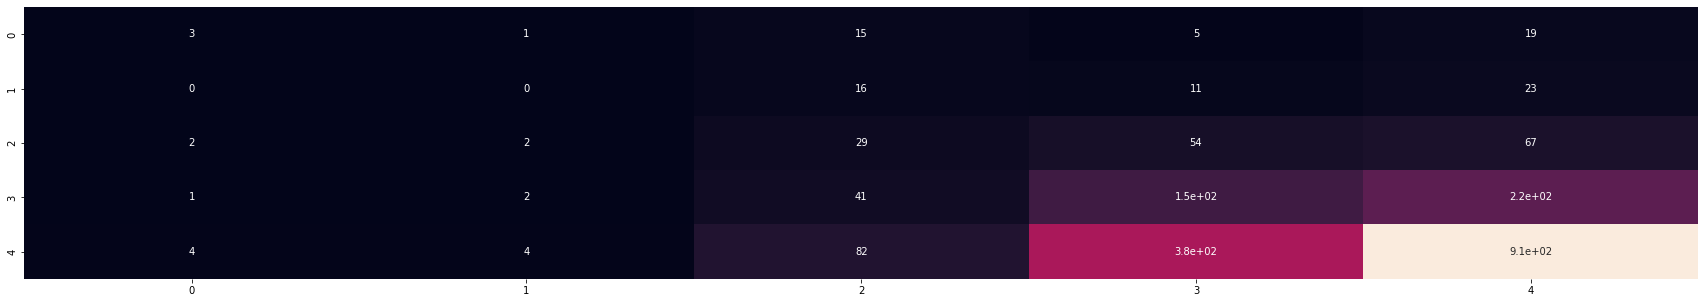

In [65]:
sns.heatmap(confusion_matrix(test_y, predicted_y_conv), annot = True, cbar = False)

In [66]:
print(classification_report(test_y, predicted_y_conv))

              precision    recall  f1-score   support

         0.0       0.30      0.07      0.11        43
         1.0       0.00      0.00      0.00        50
         2.0       0.16      0.19      0.17       154
         3.0       0.25      0.36      0.30       417
         4.0       0.73      0.66      0.69      1387

    accuracy                           0.53      2051
   macro avg       0.29      0.26      0.26      2051
weighted avg       0.57      0.53      0.55      2051



Добавление одного сверточного слоя в модель немного улучшило результат но слишком незначительно чтобы делать какие-то выводы, нужно проводить дальнейшее исследование

### Итоговое сравнение алгоритмов

In [67]:
df1 = pd.DataFrame(classification_report(test_y, predicted_y, output_dict=True))
df2 = pd.DataFrame(classification_report(test_y, predicted_y_conv, output_dict=True))

In [68]:
df1.compare(df2, align_axis = 0)

0.0       1.0       2.0       3.0       4.0  accuracy  \
precision self   0.188406  0.044776  0.113924  0.230616  0.827707  0.441736   
          other  0.300000  0.000000  0.158470  0.250825  0.734513  0.534861   
recall    self   0.302326  0.060000  0.409091  0.278177  0.512617  0.441736   
          other  0.069767  0.000000  0.188312  0.364508  0.658255  0.534861   
f1-score  self   0.232143  0.051282  0.178218  0.252174  0.633126  0.441736   
          other  0.113208  0.000000  0.172107  0.297165  0.694297  0.534861   
support   self        NaN       NaN       NaN       NaN       NaN  0.441736   
          other       NaN       NaN       NaN       NaN       NaN  0.534861   

                 macro avg  weighted avg  
precision self    0.281086      0.620225  
          other   0.288762      0.565904  
recall    self    0.312442      0.441736  
          other   0.256169      0.534861  
f1-score  self    0.269388      0.498924  
          other   0.255355      0.545236  
support   self         NaN           NaN  
          other        NaN           NaN

## Вывод: Модели показали себя примерно одинаково, модель со сверточным слоем дала чуть большее accuracy (хотя обучение заняло больше времени). 

#### Нужно проводить дальнейшее исследование, возможно применить сумку слов + TF-IDF и SMOTE для балансировки классов / использовать больше данных / удалить нейтральные слова / использовать больше слоев нейросети / использовать LSTM 